# Imports

In [61]:
import numpy as np
import pandas as pd
from typing import Optional
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

In [62]:
coupon_df = pd.read_csv('data/18929485529.csv')
print(coupon_df.head())

            ID  User ID                     Time  I Language Application Name  \
0  18929485529   165559  2024-09-04T10:55:25.287  1       de            PENNY   
1  18929485529   165559  2024-09-04T10:55:25.287  2       de            PENNY   
2  18929485529   165559  2024-09-04T10:55:25.287  3       de            PENNY   
3  18929485529   165559  2024-09-04T10:55:25.287  4       de            PENNY   
4  18929485529   165559  2024-09-04T10:55:25.287  5       de            PENNY   

   Package Name                           Class Name  Context  \
0  de.penny.app  de.penny.app.main.view.MainActivity      NaN   
1  de.penny.app  de.penny.app.main.view.MainActivity      NaN   
2  de.penny.app  de.penny.app.main.view.MainActivity      NaN   
3  de.penny.app  de.penny.app.main.view.MainActivity      NaN   
4  de.penny.app  de.penny.app.main.view.MainActivity      NaN   

              View ID  View Depth                      View Class Name  \
0                 NaN           0  de.penny.app.

In [63]:
class BoundingBox:
    def __init__(self, x1, y1, x2, y2):
        self.x1 = min(x1, x2)
        self.y1 = min(y1, y2)
        self.x2 = max(x1, x2)
        self.y2 = max(y1, y2)

    def intersects(self, other: 'BoundingBox') -> bool:
        if self.x1 >= other.x2 or self.x2 <= other.x1:
            return False

        if self.y1 >= other.y2 or self.y2 <= other.y1:
            return False

        return True

    def merge(self, other: 'BoundingBox') -> 'BoundingBox':
        return BoundingBox(
            min(self.x1, other.x1),
            min(self.y1, other.y1),
            max(self.x2, other.x2),
            max(self.y2, other.y2)
        )

    def intersection(self, other: 'BoundingBox') -> Optional['BoundingBox']:
        if not self.intersects(other):
            return None

        return BoundingBox(
            max(self.x1, other.x1),
            max(self.y1, other.y1),
            min(self.x2, other.x2),
            min(self.y2, other.y2)
        )

    def area(self):
        return (self.x2 - self.x1) * (self.y2 - self.y1)

    def IoU(self, other: 'BoundingBox'):
        if not self.intersects(other):
            return 0

        inter_area = self.intersection(other).area()

        return inter_area / (self.area() + other.area() - inter_area)

    def apply_bias(self, xbias, ybias):
        return BoundingBox(
            self.x1 - xbias,
            self.y1 - ybias,
            self.x2 + xbias,
            self.y2 + ybias
        )

In [64]:
def create_bounding_box(row):
    return BoundingBox(
        row['X 1'],
        row['Y 1'],
        row['X 2'],
        row['Y 2']
    )

coupon_df_mod = coupon_df.copy()
coupon_df_mod['Bounding Box'] = coupon_df_mod.apply(create_bounding_box, axis=1)
coupon_df_mod.drop(columns=['X 1', 'Y 1', 'X 2', 'Y 2'], inplace=True)

In [65]:
grouping_columns = ['Application Name', 'Seen Timestamp']
grouped_coupon_dfs = [group for _, group in coupon_df_mod.groupby(grouping_columns)]

In [70]:
test_df = grouped_coupon_dfs[3]
num_rows = test_df.shape[0]
dists = np.empty((num_rows, num_rows))
xbias = 0
ybias = 100

for i in range(num_rows):
    for j in range(num_rows):
        dists[i, j] = 1 / (test_df['Bounding Box'].iloc[i].apply_bias(xbias, ybias).IoU(test_df['Bounding Box'].iloc[j].apply_bias(xbias, ybias)) + 0.000001)

print(dists)

[[9.99999000e-01 2.05325393e+00 1.00000000e+06 2.90157548e+01
  1.00000000e+06 1.00000000e+06 1.00000000e+06 1.00000000e+06
  1.00000000e+06 1.00000000e+06 1.00000000e+06 1.00000000e+06
  1.00000000e+06 1.00000000e+06 1.00000000e+06 1.00000000e+06
  1.00000000e+06 1.00000000e+06 1.00000000e+06 1.00000000e+06
  1.00000000e+06]
 [2.05325393e+00 9.99999000e-01 1.00000000e+06 9.94655732e+00
  1.00000000e+06 1.00000000e+06 1.00000000e+06 1.00000000e+06
  1.00000000e+06 1.00000000e+06 1.00000000e+06 1.00000000e+06
  1.00000000e+06 1.00000000e+06 1.00000000e+06 1.00000000e+06
  1.00000000e+06 1.00000000e+06 1.00000000e+06 1.00000000e+06
  1.00000000e+06]
 [1.00000000e+06 1.00000000e+06 9.99999000e-01 1.16673839e+01
  6.83346007e+00 1.00000000e+06 1.00000000e+06 1.00000000e+06
  1.00000000e+06 1.00000000e+06 1.00000000e+06 1.00000000e+06
  1.00000000e+06 1.00000000e+06 1.00000000e+06 1.00000000e+06
  1.00000000e+06 1.00000000e+06 1.00000000e+06 1.00000000e+06
  1.00000000e+06]
 [2.90157548e+01

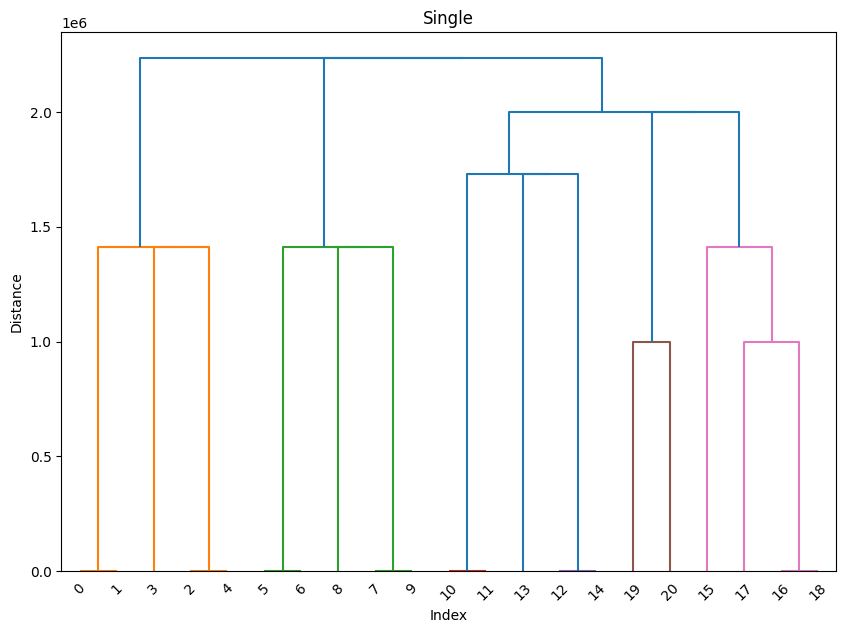

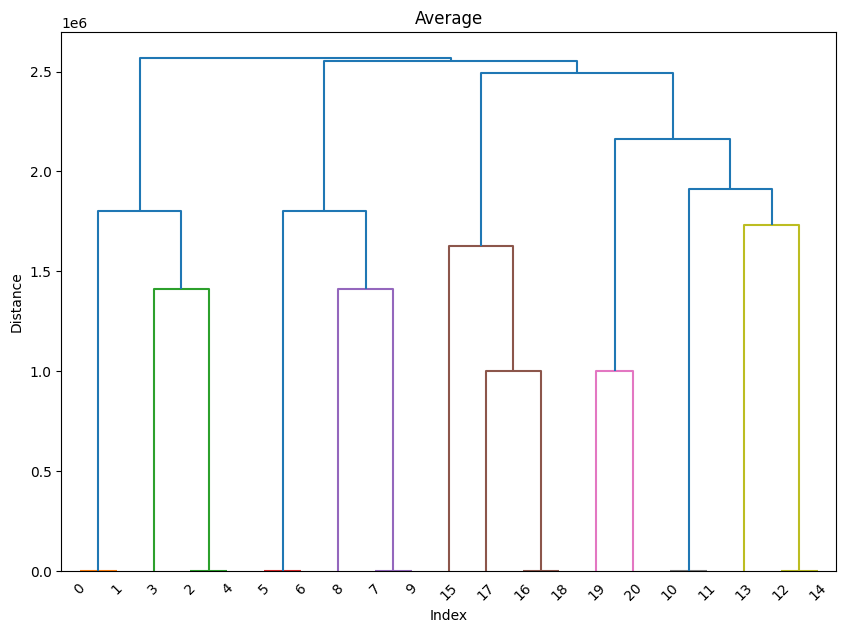

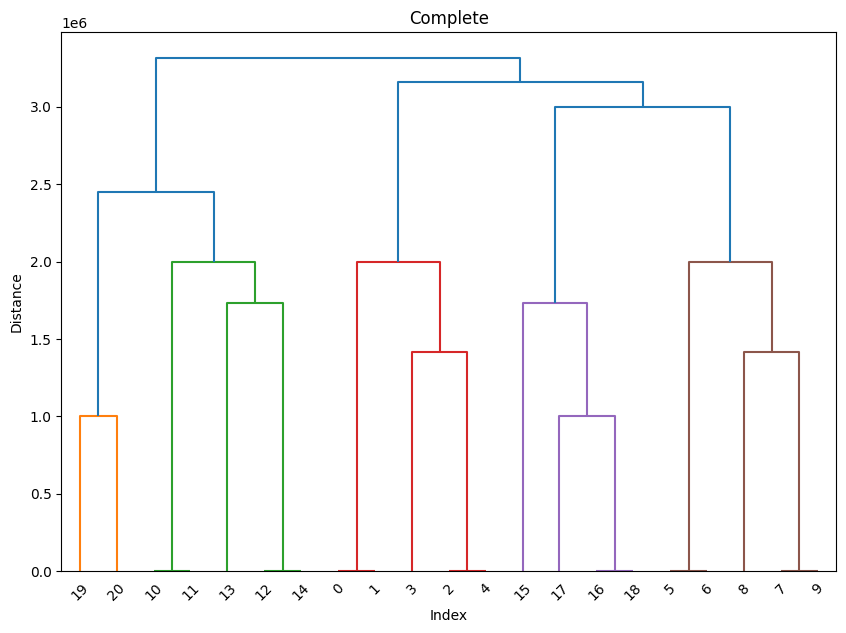

In [71]:
link_mat_single = linkage(dists, method='single')
link_mat_average = linkage(dists, method='average')
link_mat_complete = linkage(dists, method='complete')

plt.figure(figsize=(10, 7))
dendrogram(link_mat_single)
plt.title('Single')
plt.xlabel('Index')
plt.ylabel('Distance')
plt.show()

plt.figure(figsize=(10, 7))
dendrogram(link_mat_average)
plt.title('Average')
plt.xlabel('Index')
plt.ylabel('Distance')
plt.show()

plt.figure(figsize=(10, 7))
dendrogram(link_mat_complete)
plt.title('Complete')
plt.xlabel('Index')
plt.ylabel('Distance')
plt.show()

In [59]:
coupon_df[39:55]

,ID,User ID,Time,I,Language,Application Name,Package Name,Class Name,Context,View ID,View Depth,View Class Name,Text,Description,Seen Timestamp,Is Visible,X 1,Y 1,X 2,Y 2
39,18929485529,165559,2024-09-04T10:55:25.287,40,de,PENNY,de.penny.app,de.penny.app.main.view.MainActivity,NaN,NaN,11,android.widget.TextView,UVP 14.99,NaN,1725440083429,True,339,478,498,519
40,18929485529,165559,2024-09-04T10:55:25.287,41,de,PENNY,de.penny.app,de.penny.app.main.view.MainActivity,NaN,NaN,11,android.widget.TextView,9.99,NaN,1725440083429,True,356,529,482,605
41,18929485529,165559,2024-09-04T10:55:25.287,42,de,PENNY,de.penny.app,de.penny.app.main.view.MainActivity,NaN,NaN,10,android.widget.TextView,UVP,NaN,1725440083429,True,63,631,125,672
42,18929485529,165559,2024-09-04T10:55:25.287,43,de,PENNY,de.penny.app,de.penny.app.main.view.MainActivity,NaN,NaN,10,android.widget.TextView,JOHNNIE WALKER Red Label Blended Scotch,NaN,1725440083429,True,63,683,514,779
43,18929485529,165559,2024-09-04T10:55:25.287,44,de,PENNY,de.penny.app,de.penny.app.main.view.MainActivity,NaN,NaN,10,android.widget.TextView,"je 0,7 I",NaN,1725440083429,True,63,779,182,833
44,18929485529,165559,2024-09-04T10:55:25.287,45,de,PENNY,de.penny.app,de.penny.app.main.view.MainActivity,NaN,NaN,11,android.widget.TextView,UVP 0.99,NaN,1725440083429,True,862,477,1001,518
45,18929485529,165559,2024-09-04T10:55:25.287,46,de,PENNY,de.penny.app,de.penny.app.main.view.MainActivity,NaN,NaN,11,android.widget.TextView,0.75,NaN,1725440083429,True,859,528,985,604
46,18929485529,165559,2024-09-04T10:55:25.287,47,de,PENNY,de.penny.app,de.penny.app.main.view.MainActivity,NaN,NaN,10,android.widget.TextView,UVP,NaN,1725440083429,True,567,630,629,671
47,18929485529,165559,2024-09-04T10:55:25.287,48,de,PENNY,de.penny.app,de.penny.app.main.view.MainActivity,NaN,NaN,10,android.widget.TextView,SAN MIGUEL Especial,NaN,1725440083429,True,567,682,926,730
48,18929485529,165559,2024-09-04T10:55:25.287,49,de,PENNY,de.penny.app,de.penny.app.main.view.MainActivity,NaN,NaN,10,android.widget.TextView,"je 0,5 I",NaN,1725440083429,True,567,730,686,784
